## Setup

Import ROOT and set some configurations

In [1]:
import ROOT

# silence most of the roofit message (bug in ROOT saturate jupyter stream)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.NumIntegration)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Fitting)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Minimization)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.InputArguments)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Eval)
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.ERROR)

ROOT.RooStats.AsymptoticCalculator.SetPrintLevel(-1)

ROOT.enableJSVis()

Welcome to JupyROOT 6.10/06


Add some sugar. With this you will get exceptions instead of null pointers errors. Just execute and pass over.

In [2]:
def safe_factory(func):
    def wrapper(self, *args):
        result = func(self, *args)
        if not result:
            raise ValueError('invalid factory input "%s"' % args)
        return result
    return wrapper

ROOT.RooWorkspace.factory = safe_factory(ROOT.RooWorkspace.factory)

def safe_decorator(func):
    def wrapper(self, *args):
        result = func(self, *args)
        if not result:
            raise ValueError('cannot find %s' % args[0])
        return result
    return wrapper

ROOT.RooWorkspace.data = safe_decorator(ROOT.RooWorkspace.data)
ROOT.RooWorkspace.obj = safe_decorator(ROOT.RooWorkspace.obj)
ROOT.RooWorkspace.var = safe_decorator(ROOT.RooWorkspace.var)
ROOT.RooWorkspace.pdf = safe_decorator(ROOT.RooWorkspace.pdf)

def loop_iterator(iterator):
  object = iterator.Next()
  while object:
    yield object
    object = iterator.Next()

def iter_collection(rooAbsCollection):
  iterator = rooAbsCollection.createIterator()
  return loop_iterator(iterator)

def show_graph(node):
    """
    display the computational graph relative to a statistical model
    """
    from IPython.display import HTML, IFrame, Image, SVG, Latex
    import re
    import os
    prefix = "graph_%s" % node.GetName()
    node.graphVizTree("%s.dot" % prefix)
    os.system("dot -Tsvg {0}.dot > {0}.svg; rm {0}.dot".format(prefix))
    s = SVG("{}.svg".format(prefix))
    s.data = re.sub(r'width="[0-9]+pt"', r'width="90%"', s.data)
    s.data = re.sub(r'height="[0-9]+pt"', r'height=""', s.data);
    return s

def import_ws(ws, obj):
    # dear ROOT: `import` is a keyword in python
    getattr(ws, 'import')(obj)
    
# ROOT.RooDataSet.setDefaultStorageType(ROOT.RooAbsData.Tree)

## Create workspace
Our model is a mixture of background and signal. Our observable is the invariant mass, which is not just an integer counting the number of events, but it is a continuos variable: our analysis is a shape analysis.

The shape of the signal is a simple gaussian, for the background an exponential.

The signal is described by the truth value of the mass (mH) which is assumed to be equal to the position of the gaussian peak. The number of signal events is expressed as the product of luminosity, cross section (times branching ratio) and efficiency. The cross section is the parameter of intereset. We assume systematic on the luminosity, efficiency and resolution.

Since all the parameters of the background are data-driven, we are fitting the model to data to get the parameters of the background using a s+b fit. Since the background is data-driven there are no systematic on it. The only a-priori assumption is the kind of function used to model the shape (exponential): for simplicity no systematic is added.



In [21]:
# define some constants, values are in pb(^-1) and GeV
PRESENT_LUMINOSITY = 50E3 
XSECTION_X_BR_SM = 0.1 
VISIBLE_XSECTION_BKG = 10  # the background will be fitted on data, here just an reasonable number

ws = ROOT.RooWorkspace('ws')               # create the workspace
mass = ws.factory("mass[105, 160]")        # observable: invariant mass with a range
# define the parameter of intereset (POI): we will fit / set limits on the signal cross section
# discovery is based on the exclusion of cross section == 0
ws.factory("xsection_x_br[-0.1, 0.5]").setVal(XSECTION_X_BR_SM)  # pb
poi = xsection = ws.var("xsection_x_br")
ws.factory('nominal_efficiency[0.5]')
ws.factory('nominal_luminosity[10E3]')     # only 10/fb
ws.factory('nominal_resolution[1]')        # nominal mass detector resolution at ~125 GeV

# relative uncertainties
ws.factory('sigma_luminosity[0.05]')       # luminosity uncertainty on the signal yield
ws.factory('sigma_efficiency[0.02]')       # efficiency uncertainty on the signal yield
ws.factory('sigma_resolution[0.02]')       # energy resolution uncertainty on the peak width

# the background parameters (number of events and slope of the shape) are not know
# we are setting them to a reasonable values here, but we will set them to the best value
# from a signal+background fit on data
ws.factory('bkg_slope[-0.02, -0.5, -0.001]')
ws.factory('xsection_bkg[0, 100E3]').setVal(VISIBLE_XSECTION_BKG)
# parametrize the number of background events as a functinon of the luminosity so that
# we can do extrapolation to different luminosities
ws.factory('prod:nbkg(nominal_luminosity, xsection_bkg)')

# signal parameters
ws.factory("mH[125, 110, 145]").setConstant()   # mass of the resonance [GeV]
                                                # forget about natural width, dominated by det resolution

# signal peak position
ws.factory('expr:peak("@0", {mH})')   # peak position for signal, assume it to be equal to mH
# signal width
ws.factory('expr:resolution("@0 * (1 + @1 * @2)", {nominal_resolution, sigma_resolution, theta_resolution[0, -5, 5]})')
# signal shape
signal = ws.factory("RooGaussian:signal_shape(mass, peak, resolution)")

# luminosity
ws.factory('expr:luminosity("@0 * (exp(@1 * @2))", {nominal_luminosity, sigma_luminosity, theta_luminosity[0, -5, 5]})')
# efficiency
ws.factory('expr:efficiency("@0 * (exp(@1 * @2))", {nominal_efficiency, sigma_efficiency, theta_efficiency[0, -5, 5]})')
# expected signal theory
ws.factory('prod:nsignal(luminosity, xsection_x_br, efficiency)')

# background shape
ws.factory("RooExponential:background_shape(mass, bkg_slope)")
# no uncertainty on background since it is fully data-driven

ws.factory("SUM:phys_pdf(nsignal * signal_shape, nbkg * background_shape)")
ws.factory("RooGaussian:constrain_resolution(global_resolution[0, -5, 5], theta_resolution, 1)")
ws.factory("RooGaussian:constrain_luminosity(global_luminosity[0, -5, 5], theta_luminosity, 1)")
ws.factory("RooGaussian:constrain_efficiency(global_efficiency[0, -5, 5], theta_efficiency, 1)")
ws.factory("PROD:constraints(constrain_luminosity, constrain_resolution, constrain_efficiency)")

ws.defineSet('global_observables', ws.allVars().selectByName('global_*'))
ROOT.RooStats.SetAllConstant(ws.set('global_observables'))
ws.defineSet('pulls', ws.allVars().selectByName('theta_*'))
ws.defineSet('nuis', ws.set('pulls'))
nuis = ws.set('nuis')
nuis.add(ws.var('bkg_slope'))
nuis.add(ws.var('xsection_bkg'))

model = ws.factory("PROD:model(phys_pdf, constraints)")


######## remove this ##############
ROOT.RooDataSet.setDefaultStorageType(ROOT.RooAbsData.Tree)
real_data = model.generate(ROOT.RooArgSet(ws.var('mass')))
f = ROOT.TFile.Open('real_data_10fb.root', 'recreate')
tree = real_data.tree()
tree.SetName('data')
tree.Write()
f.Close()
###################################

# import real data from a TTree
f = ROOT.TFile.Open('real_data_10fb.root')
tree = f.Get("data")
data_unbinned = ROOT.RooDataSet('data_unbinned', 'real data unbinned',
                                ROOT.RooArgSet(mass),
                                ROOT.RooFit.Import(tree))




# since we have a lot of data it is more convenient to use a binned version of the data
# (and of the likelihood, RooFit will manage that)
data_binned = ROOT.RooDataHist("data_binned", "binned real data", ROOT.RooArgSet(mass), data_unbinned)
import_ws(ws, data_unbinned)
import_ws(ws, data_binned)
# since we don't know where the execess keep mH free just for this fit
ws.var('mH').setConstant(False)
print "before fit"
print "=" * 80
print "bkg vis xsection: ", ws.var('xsection_bkg').getVal()
print "bkg slope: ", ws.var('bkg_slope').getVal()
model.fitTo(data_binned, ROOT.RooFit.PrintLevel(-1))    # fit on data: only to get background parameters
print "after fit"
print "=" * 80
print "bkg vis xsection: ", ws.var('xsection_bkg').getVal()
print "bkg slope: ", ws.var('bkg_slope').getVal()
ws.var('mH').setVal(125)           # reset mH value to our test value
ws.var('mH').setConstant(True)     # we test each mH hypothesis one by one with separate tests
ws.var('xsection_x_br').setVal(XSECTION_X_BR_SM)  # reset xsection to SM value

# in case we want to go back to this values, save a snapshot of all the variables
ws.saveSnapshot('data_fit', ws.allVars())

# create the model configs
# model config are needed to specify the meaning of the variables from the
# interference point of view: what are the observables, the nuisance parameters, ...
# start from a generic model config
model_config = ROOT.RooStats.ModelConfig('model_config', ws)
model_config.SetPdf('model')
model_config.SetParametersOfInterest('xsection_x_br')
model_config.SetNuisanceParameters(ws.set("nuis"))
model_config.SetGlobalObservables(ws.allVars().selectByName("global_*"))
model_config.SetObservables('mass')
import_ws(ws, model_config)

# create a model config with nominal signal
sb_model_config = model_config.Clone()
sb_model_config.SetName("sb_model_config");      
xsection.setVal(XSECTION_X_BR_SM)
sb_model_config.SetSnapshot(ROOT.RooArgSet(poi))
import_ws(ws, sb_model_config)

# create a model config without signal
b_model_config = sb_model_config.Clone()
b_model_config.SetName("b_model_config")
poi.setVal(0)
b_model_config.SetSnapshot(ROOT.RooArgSet(poi))
import_ws(ws, b_model_config)


# creta datasets (toy and Asimov) based on the SM values (s+b)
poi.setVal(XSECTION_X_BR_SM)
data_toy_unbinned = model.generate(model_config.GetObservables())
data_toy_binned = model.generateBinned(model_config.GetObservables())
data_asimov = model.generateBinned(model_config.GetObservables(), ROOT.RooFit.ExpectedData())
data_toy_binned.SetName('data_toy_binned')
data_asimov.SetName('data_asimov')

import_ws(ws, data_toy_binned)
import_ws(ws, data_asimov)

ws.writeToFile('workspace.root')

before fit
bkg vis xsection:  10.0
bkg slope:  -0.02
after fit
bkg vis xsection:  10.0035753728
bkg slope:  -0.0201963778696


False

***EXERCIZE (skip)***: add an uncertainty on the mass-scale with a gaussian constrain of few per-mill

***EXERCIZE (skip)***: add toy sample in the workspace with no signal

## Debug the workspace
Plot the computational graph

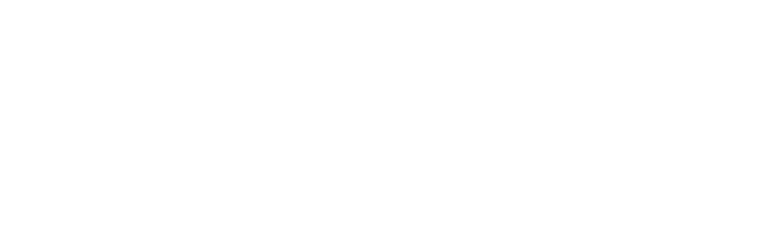

In [32]:
show_graph(ws.pdf('signal_shape'))  # only the signal model

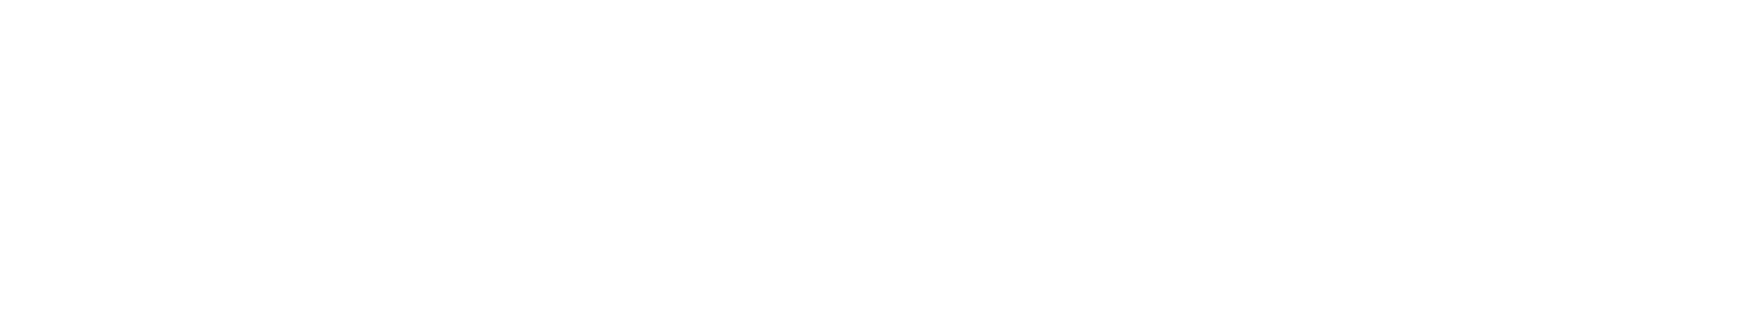

In [33]:
show_graph(ws.pdf('phys_pdf'))  # signal + background pdf (no constraints)

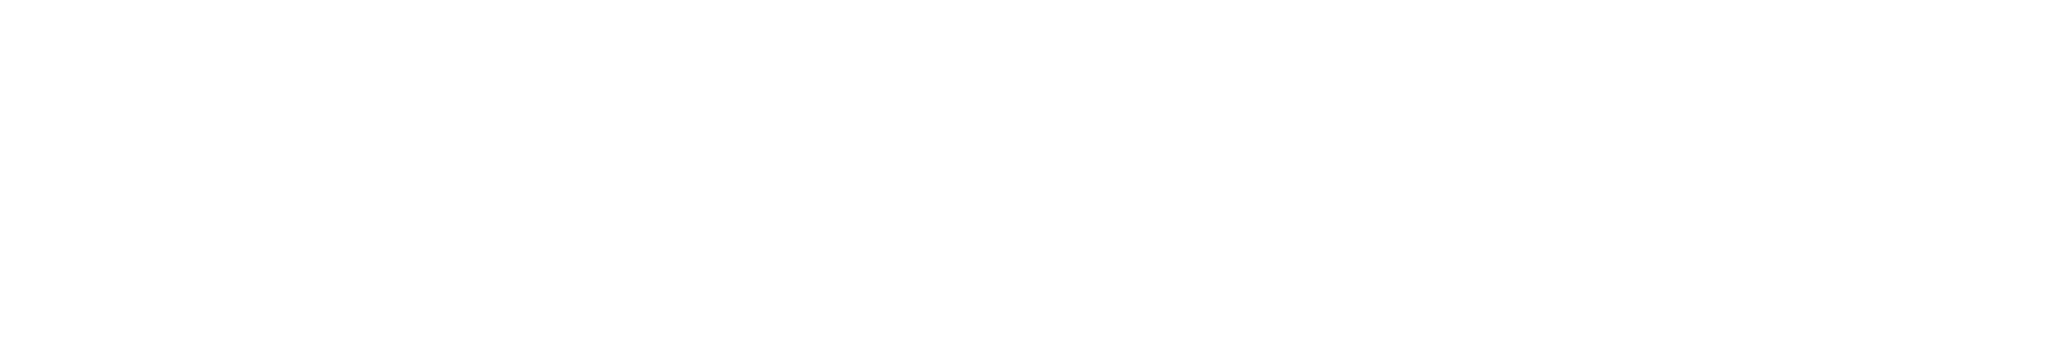

In [34]:
show_graph(model)  # full model

## Signal shape

In [35]:
canvas = ROOT.TCanvas()
frame = mass.frame()
for mH_value in [110, 120, 150]:
    ws.var('mH').setVal(mH_value)
    ws.pdf('signal_shape').plotOn(frame)
ws.loadSnapshot('data_fit')
frame.Draw()
canvas.Draw()

Check the value of parameters affected by systematics

In [36]:
canvas = ROOT.TCanvas("", "", 800, 300)
effects = ['efficiency', 'luminosity', 'resolution']
canvas.DivideSquare(len(effects))
for i, effect in enumerate(effects, 1):
    canvas.cd(i)
    frame = ws.var('theta_%s' % effect).frame()
    ws.obj(effect).plotOn(frame)
    frame.Draw()
    canvas.cd(i).SetGrid()
canvas.Draw()

Try to fit on Asimov, should get the same parameters used to generate the Asimov

In [38]:
fit_result = model.fitTo(data_asimov,
                         ROOT.RooFit.Minos(),
                         ROOT.RooFit.PrintLevel(-1),
                         ROOT.RooFit.Save())
fit_result.Print("V")


  RooFitResult: minimized FCN value: -659633, estimated distance to minimum: 9.12525e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 MINOS=0 

    Constant Parameter    Value     
  --------------------  ------------
     global_efficiency    0.0000e+00
     global_luminosity    0.0000e+00
     global_resolution    0.0000e+00
                    mH    1.2500e+02
    nominal_efficiency    5.0000e-01
    nominal_luminosity    1.0000e+04
    nominal_resolution    1.0000e+00
      sigma_efficiency    5.0000e-02
      sigma_luminosity    2.0000e-02
      sigma_resolution    2.0000e-02

    Floating Parameter  InitialValue    FinalValue (+HiError,-LoError)    GblCorr.
  --------------------  ------------  ----------------------------------  --------
             bkg_slope   -2.0200e-02   -2.0193e-02 (+2.04e-04,-2.07e-04)  <none>
      theta_efficiency   -3.6738e-03   -3.5291e-04 (+1.00e+00,-1.00e+00)  <none>
      t

## Check expected correlations

In [40]:
ROOT.gStyle.SetPalette(ROOT.kThermometer)  # why not working?
canvas = ROOT.TCanvas()
correlation_matrix = fit_result.correlationHist()
correlation_matrix.Draw("textcolz")
correlation_matrix.GetZaxis().SetRangeUser(-0.6, 0.6)
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: correlation_matrix (Potential memory leak).


# Visualize
Plot Asimov dataset with its fit, with all the components. The signal peak is quite small by eye, but thanks to the high statistics, it is quite significative

In [41]:
mass_frame = mass.frame()
data_asimov.plotOn(mass_frame, ROOT.RooFit.Name('curve_data'))

model.plotOn(mass_frame, ROOT.RooFit.VisualizeError(fit_result, 3),
             ROOT.RooFit.Name('curve_signal_background_fit'))

model.plotOn(mass_frame, ROOT.RooFit.Components('background_shape'),
             ROOT.RooFit.LineStyle(ROOT.kDashed),
             ROOT.RooFit.Name('curve_background_component'))

model.plotOn(mass_frame, ROOT.RooFit.Components('signal_shape'),
             ROOT.RooFit.LineStyle(ROOT.kDashed),
             ROOT.RooFit.Name('curve_signal_component'))

data_asimov.plotOn(mass_frame)

canvas = ROOT.TCanvas()
mass_frame.Draw()
canvas.Draw()

*** Exercize (skip) *** Plot the pulls (data - fit) / error for each bin (se RooFrame::pullHist)

In [42]:
canvas = ROOT.TCanvas()
pull_hist = mass_frame.pullHist('curve_data', 'curve_background_component')
pull_hist.Draw()
canvas.Draw()

Check the number of fitted signal and backgrounde events

In [43]:
print 'nsignal', ws.obj('nsignal').getVal()
print 'nbackground', ws.obj('nbkg').getVal()

nsignal 499.893351502
nbackground 100034.980902


Check which variables are constant or free in the model

In [44]:
# print constant variables
ws.allVars().selectByAttrib("Constant", True).Print("V")

  1) RooRealVar:: nominal_efficiency = 0.5
  2) RooRealVar:: nominal_luminosity = 10000
  3) RooRealVar:: nominal_resolution = 1
  4) RooRealVar::   sigma_luminosity = 0.02
  5) RooRealVar::   sigma_efficiency = 0.05
  6) RooRealVar::   sigma_resolution = 0.02
  7) RooRealVar::                 mH = 125 +/- 0.244489
  8) RooRealVar::  global_resolution = 0
  9) RooRealVar::  global_luminosity = 0
 10) RooRealVar::  global_efficiency = 0


In [45]:
# print non-constant variable (may be fitted)
ws.allVars().selectByAttrib("Constant", False).Print("V")

  1) RooRealVar::             mass = 132.5
  2) RooRealVar::    xsection_x_br = 0.0999864 +/- (-0.0186117,0.0194519)
  3) RooRealVar::        bkg_slope = -0.0201931 +/- (-0.000206598,0.000204373)
  4) RooRealVar::     xsection_bkg = 10.0035 +/- (-0.0327626,0.0329188)
  5) RooRealVar:: theta_resolution = 0.0050509 +/- (-1.00207,0.991558)
  6) RooRealVar:: theta_luminosity = -0.00299503 +/- (-0.997038,1.00304)
  7) RooRealVar:: theta_efficiency = -0.000352913 +/- (-0.999691,1.0004)


In [46]:
model_config.GetNuisanceParameters().Print("V")

  1) RooRealVar:: theta_resolution = 0.0050509 +/- (-1.00207,0.991558)
  2) RooRealVar:: theta_luminosity = -0.00299503 +/- (-0.997038,1.00304)
  3) RooRealVar:: theta_efficiency = -0.000352913 +/- (-0.999691,1.0004)
  4) RooRealVar::        bkg_slope = -0.0201931 +/- (-0.000206598,0.000204373)
  5) RooRealVar::     xsection_bkg = 10.0035 +/- (-0.0327626,0.0329188)


## Check the pulls

It is important to check that the nuisance parameters are compatible with 0, otherwise it means that there is a tension between our channel and the axiliary measurement (efficiency measurent, energy scale, ...). Usually channels are not sensitive to constrain systematic effects (otherwise these would have been used to do the measurement).

In [48]:
ws.set('pulls').Print("V")

  1) RooRealVar:: theta_resolution = 0.0050509 +/- (-1.00207,0.991558)
  2) RooRealVar:: theta_luminosity = -0.00299503 +/- (-0.997038,1.00304)
  3) RooRealVar:: theta_efficiency = -0.000352913 +/- (-0.999691,1.0004)
